### 1. Import modules

In [1]:
# Preprocessing
import numpy as np
import pandas as pd
import pyodbc
from datetime import datetime, timedelta
from scipy.stats import skew
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
import matplotlib.pyplot as plt

# ML
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

# FFNN
#from keras.models import Sequential
#from keras.layers import Dense

# Model selection
import shap
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error, r2_score
from tabulate import tabulate


C:\Users\l.hanen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Import data

In [2]:
# Replace server name if source changes
server = 'AZ-ODB0\ODBWB'
database = 'OnderzoeksDB_WB'

# Create a connection string
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database}'

# Establish connection
connection = pyodbc.connect(connection_string)

# Create SQL query string
query = 'SELECT * FROM Regas_Problematiek'

# Execute the query and fetch the data into a Pandas DataFrame
df_og = pd.read_sql(query, connection)

# Close the connection
connection.close()

<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:2: SyntaxWarning: invalid escape sequence '\O'
C:\Users\l.hanen\AppData\Local\Temp\ipykernel_38500\541049490.py:2: SyntaxWarning: invalid escape sequence '\O'
  server = 'AZ-ODB0\ODBWB'
C:\Users\l.hanen\AppData\Local\Temp\ipykernel_38500\541049490.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_og = pd.read_sql(query, connection)


### 3. Copy desired columns

In [3]:
# Reorder columns and make copy of df
df = df_og[[#'Casus',
            #'Persoonsnummer',
            'Gemeente',                                         # OH, freq and/or geo encoding                                      #done
            #'JaarStartCasus',
            'Datum melding',                                    # Year as is, cyclical datetime encoding for months and days        #done, day of month AND week encoding
            'Geboortejaar',                                     # Use to construct age                                              #done
            'Geboortemaand',                                    # Use to construct age                                              #done
            'Soort melder',                                     # OH and/or freq encoding                                           #done
            'Aanwezigheid minderjarige kinderen',               # Dummy                                                             #done
            'Is er sprake van huiselijk geweld?',               # Dummy                                                             #done
            'Is er sprake van agressie / geweld?',              # Dummy                                                             #done
            #'Inhoud melding',
            #'E33 melding',
            'Wijk-GGD',                                         # Dummy                                                             #done
            'Melding hoe ontvangen',                            # OH and/or freq encoding                                           #done
            'Vermoeden van problematiek',                       # Multi OH and/or multi (?) freq encoding                           #done
            'Eerste advies',                                    # OH and/or freq encoding                                           #done

            # EINDE MELDINGSFASE

            #'Hoofdprobleem (1 antwoord mogelijk)',
            #'Subproblemen (meerdere antwoorden mogelijk)',
            #'Besproken op datum',
            #'Inhoud',
            #'Contact met',
            #'Soort contact',
            'Datum',
            'Medewerker',                                       # OH and/or freq encoding                                           #done

            # EINDE TRAJECT/ONDERZOEKSFASE

            'Datum afsluiting',
            #'Reden afsluiting',
            #'Voortgang proces door',
            #'Bijzonderheden',
            #'Soort instelling verwijzing',
            
            # EINDE SLUITINGSFASE

            'DubbelRecord'                                      # Dummy                                                             #done
            ]].copy() # All hashed columns are not needed

### 4. Preprocessing

#### 4.1 Change column Dtypes

In [4]:
# Define function to preprocess boolean-like values for casting
def convert_to_bool(column):
    bool_mapping = {'y': True, 'Ja': True, 'n': False, 'Nee': False}
    return bool_mapping.get(column, np.NaN)

# List all columns to be casted
columns_to_convert = ['Aanwezigheid minderjarige kinderen', 
                      'Is er sprake van huiselijk geweld?', 
                      'Is er sprake van agressie / geweld?', 
                      #'E33 melding', 
                      'Wijk-GGD', 
                      'DubbelRecord']

# Cast columns
for col in columns_to_convert:
    df[col] = df[col].apply(convert_to_bool)

In [5]:
# List all columns to be casted
convert_dict = {#'Casus': object,
                #'Persoonsnummer': object,
                'Geboortejaar': object,
                'Geboortemaand': object,
                #'JaarStartCasus': object,
                
                'Gemeente': 'category',
                'Soort melder': 'category',
                'Melding hoe ontvangen': 'category',
                'Eerste advies': 'category',
                'Medewerker': 'category',
                #'Hoofdprobleem (1 antwoord mogelijk)': 'category',
                #'Reden afsluiting': 'category',
                #'Voortgang proces door': 'category',
                #'Soort instelling verwijzing': 'category',

                'Aanwezigheid minderjarige kinderen': 'boolean',
                'Is er sprake van huiselijk geweld?': 'boolean',
                'Is er sprake van agressie / geweld?': 'boolean',
                #'E33 melding': 'boolean',
                'Wijk-GGD': 'boolean',
                'DubbelRecord': 'boolean'
                }

# Cast columns
df = df.astype(convert_dict)

# Change date column Dtypes
df[['Datum afsluiting',
    'Datum melding']] = df[['Datum afsluiting',
                            'Datum melding']].apply(pd.to_datetime)

# Rename date columns for .apply function on multiple column names
df.rename(columns={"Datum afsluiting": "Datum_afsluiting",
                   "Datum melding": "Datum_melding",
                   #"Besproken op datum": "Besproken_op_datum",
                   "Soort melder": "Soort_melder",
                   "Aanwezigheid minderjarige kinderen": "Aanwezigheid_minderjarige_kinderen",
                   "Is er sprake van huiselijk geweld?": "Is_er_sprake_van_huiselijk_geweld?",
                   "Is er sprake van agressie / geweld?": "Is_er_sprake_van_agressie_/_geweld?",
                   "Inhoud melding": "Inhoud_melding",
                   #"E33 melding": "E33_melding",
                   "Melding hoe ontvangen": "Melding_hoe_ontvangen",
                   "Vermoeden van problematiek": "Vermoeden_van_problematiek",
                   "Eerste advies": "Eerste_advies"}, inplace=True)

# Visualize df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10083 entries, 0 to 10082
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Gemeente                             10042 non-null  category      
 1   Datum_melding                        9307 non-null   datetime64[ns]
 2   Geboortejaar                         10083 non-null  object        
 3   Geboortemaand                        10083 non-null  object        
 4   Soort_melder                         9304 non-null   category      
 5   Aanwezigheid_minderjarige_kinderen   2199 non-null   boolean       
 6   Is_er_sprake_van_huiselijk_geweld?   1687 non-null   boolean       
 7   Is_er_sprake_van_agressie_/_geweld?  1826 non-null   boolean       
 8   Wijk-GGD                             5058 non-null   boolean       
 9   Melding_hoe_ontvangen                9307 non-null   category      
 10  Vermoeden_

#### 4.2 Transform columns

In [6]:
# Replace missing values with today's date
df['Datum_afsluiting'].fillna(datetime.today().date(), inplace=True)

C:\Users\l.hanen\AppData\Local\Temp\ipykernel_38500\3541983923.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2024-04-10' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df['Datum_afsluiting'].fillna(datetime.today().date(), inplace=True)


In [7]:
# Function to convert string of dates to list of datetime objects
def string_to_datelist(date_string):
    # Return empty list if no intervention dates are registered
    if not date_string:
        return []
    # Split by comma's and add to list
    else:
        date_list = date_string.split(', ')
        date_list = [datetime.strptime(date, '%Y-%m-%d').date() for date in date_list]
        return date_list

# Overwrite the column with the transformed version
df['Datum'] = df['Datum'].apply(string_to_datelist)
df_og['Datum'] = df_og['Datum'].apply(string_to_datelist)

In [8]:
# Function to convert string to list of strings
def string_to_list(string):
    # Return empty list if no string is provided
    if not string:
        return []
    # Split by comma's and add to list
    else:
        list_of_strings = string.split(', ')
        list_of_strings = [string for string in list_of_strings]
        return list_of_strings

# Overwrite the column with the transformed version
df['Vermoeden_van_problematiek'] = df['Vermoeden_van_problematiek'].apply(string_to_list)

In [9]:
# Function to convert invalid municipalities to 'outside_WB'
def remove_invalid_municipalities(string):
    WB_regions = ['Alphen-Chaam',
                  'Altena',
                  'Baarle-Nassau',
                  'Bergen op Zoom',
                  'Breda',
                  'Drimmelen',
                  'Etten-Leur',
                  'Geertruidenberg',
                  'Halderberge',
                  'Moerdijk',
                  'Oosterhout',
                  'Roosendaal',
                  'Rucphen',
                  'Steenbergen',
                  'Woensdrecht',
                  'Zundert']
    Altena_regions = ['Aalburg',
                      'Werkendam',
                      'Woudrichem']
    
    if string in Altena_regions:
        return 'Altena'
    elif string not in WB_regions:
        return 'outside_WB'
    else:
        return string

# Overwrite the column with the transformed version
df['Gemeente'] = df['Gemeente'].apply(remove_invalid_municipalities)

### 5. Exclude rows

In [10]:
# Drop all rows with condition 'Onverzekerde zorg GGD GHOR NL'
df.drop(df[df['Vermoeden_van_problematiek'] == 'Onverzekerde zorg GGD GHOR NL'].index, inplace=True)

# Dropping rows where 'Datum_melding' column is empty
df.dropna(subset=['Datum_melding'], inplace=True)

In [11]:
# Get the first intervention date globally
min_date = datetime.now().date()
for date_list in df['Datum']:
    if date_list:
        if min(date_list) < min_date:
            min_date = min(date_list)

# Drop every row that has a date of notification before the date of the first intervention
df.drop(df[df['Datum_melding'].dt.date < min_date].index, inplace=True)

### 6. Feature engineering

In [12]:
# Create X and y where feature engineered columns can be stored
X = pd.DataFrame()
y = pd.DataFrame()

#### 6.1 Target variables

##### 6.1.1 'Dagen_tot_laatst'

In [13]:
# Function to convert string of dates to list of datetime objects
def get_n_businessdays(date_notification, dates_interventions):
    if dates_interventions == []:
        return 0
    else:
        werkdagen = pd.bdate_range(date_notification, max(dates_interventions)).shape[0]
        return int(werkdagen)

# Add the calculated days to a new column
y['Dagen_tot_laatst'] = df.apply(lambda x: get_n_businessdays(x.Datum_melding, x.Datum), axis=1)

# WARNING: If max intervention date is sooner than date of notification, days = 0

##### 6.1.2 'No_interventies'

In [14]:
# Define the function to calculate the amount of interventions
def get_n_interventions(dates):
    if not dates:
        return 0
    else:
        return len(dates)

# Add the calculated amount of interventions to a new column
y['No_interventions'] = df['Datum'].apply(get_n_interventions)

#### 6.2 Features

##### 6.2.1 Features directly taken from original df

##### 6.2.2 'Leeftijd_melding'

In [15]:
# Define the function to calculate the age at notification date
def get_age(birth_year, birth_month, notification_date):
    notification_year = notification_date.year
    notification_month = notification_date.month

    age = notification_year - birth_year
    if notification_month < birth_month:
        age -= 1
    
    return age

# Add the calculated ages to a new column
X['Leeftijd_melding'] = df.apply(lambda x: get_age(x.Geboortejaar, x.Geboortemaand, x.Datum_melding), axis=1)

##### 6.2.3 Categorical features

In [16]:
# Define functione to encode input variables
def encode_and_concat(original_df, column_name, new_df, encoding_str):
    
    if encoding_str == 'freq':
        # Frequency encoding
        original_df_filled = original_df[column_name].astype(str)
        freq_results = original_df_filled.value_counts()
        new_col_name_freq = f'{column_name}_count'
        new_df[new_col_name_freq] = original_df_filled.map(freq_results)

    elif encoding_str == 'both':
        # Frequency encoding
        original_df_filled = original_df[column_name].astype(str)
        freq_results = original_df_filled.value_counts()
        new_col_name_freq = f'{column_name}_count'
        new_df[new_col_name_freq] = original_df_filled.map(freq_results)
        
        # Dummy encoding
        dummy_columns = pd.get_dummies(original_df[column_name], prefix=column_name, prefix_sep='=', drop_first=True, dummy_na=True)
        new_df = pd.concat([new_df, dummy_columns], axis=1)

    else:
        # Dummy encoding
        dummy_columns = pd.get_dummies(original_df[column_name], prefix=column_name, prefix_sep='=', drop_first=True, dummy_na=True)
        new_df = pd.concat([new_df, dummy_columns], axis=1)
    
    for column in new_df.columns:
        new_df.rename(columns={column: column.replace('<', '').replace('>', '')}, inplace=True)

    return new_df

X = encode_and_concat(df, 'Gemeente', X, 'freq')
X = encode_and_concat(df, 'Soort_melder', X, 'freq')
X = encode_and_concat(df, 'Eerste_advies', X, 'freq')
X = encode_and_concat(df, 'Medewerker', X, 'freq')
X = encode_and_concat(df, 'Melding_hoe_ontvangen', X, 'freq')

X = encode_and_concat(df, 'Wijk-GGD', X, 'dummy')
X = encode_and_concat(df, 'Aanwezigheid_minderjarige_kinderen', X, 'dummy')
X = encode_and_concat(df, 'Is_er_sprake_van_huiselijk_geweld?', X, 'dummy')
X = encode_and_concat(df, 'Is_er_sprake_van_agressie_/_geweld?', X, 'dummy')

X = encode_and_concat(df, 'DubbelRecord', X, 'dummy')

##### 6.2.4 Multicategorical features

In [17]:
# Define the function to transform to OH encoded format
def multi_oh_encode_and_concat(original_df, column_name, new_df):
    ml_encoder = MultiLabelBinarizer()
    oh_results = ml_encoder.fit_transform(original_df[column_name])
    column_names = [f"{column_name}_{category}" for category in ml_encoder.classes_]
    oh_columns = pd.DataFrame(oh_results, columns=column_names)
    new_df = pd.concat([new_df, oh_columns.set_index(new_df.index)], axis=1)    
    return new_df

X = multi_oh_encode_and_concat(df, 'Vermoeden_van_problematiek', X)

In [18]:
# Define the function to transform column to count of items
def len_and_concat(original_df, column_name, new_df):
    new_df[f'{column_name}_len'] = original_df[column_name].apply(lambda x: len(x))
    return new_df

X = len_and_concat(df, 'Vermoeden_van_problematiek', X)

##### 6.2.5 Date features

6.2.5.1 Extract year from date value

In [19]:
# Define the function to extract the year from a datetime value
def year_and_concat(original_df, column_name, new_df):
    new_df[f'year_{column_name}'] = original_df[column_name].dt.year
    return new_df

X = year_and_concat(df, 'Datum_melding', X)

6.2.5.2 Cyclic encoding of month

In [20]:
# Define the function to extract the month from a datetime value and perform cyclical encoding
def month_and_concat(original_df, column_name, new_df):
    if original_df[column_name].dtype == 'datetime64[ns]':
        month = original_df[column_name].dt.month
    else:
        month = original_df[column_name].astype(int)
    new_df[f'month_{column_name}'] = np.sin(2 * np.pi * month/12.0)
    return new_df

X = month_and_concat(df, 'Datum_melding', X)
#X = month_and_concat(df, 'Geboortemaand', X)

6.2.5.3 Cyclic encoding of day of month

In [21]:
# Define the function to extract the day from a datetime value and perform monthly cyclical encoding
def dayofmonth_and_concat(original_df, column_name, new_df):
    days_in_month = original_df[column_name].dt.daysinmonth
    current_day = original_df[column_name].dt.day
    new_df[f'day_{column_name}'] = np.sin(2 * np.pi * current_day/days_in_month)
    return new_df

X = dayofmonth_and_concat(df, 'Datum_melding', X)

6.2.5.4 Cyclic encoding of day of week

In [22]:
# Define the function to extract the day from a datetime value and perform monthly cyclical encoding
def dayofweek_and_concat(original_df, column_name, new_df):
    current_day = original_df[column_name].dt.dayofweek
    new_df[f'day_{column_name}'] = np.sin(2 * np.pi * current_day/7.0)
    return new_df

X = dayofweek_and_concat(df, 'Datum_melding', X)

##### 6.2.6 Workload features

In [23]:
def workload_week_concat(original_df, new_df, workload_type='both'):
    workload_types = ['interventions', 'cases', 'both']
    if workload_type not in workload_types:
        raise ValueError(f'Invalid workload type. Expected one of: {workload_types}')
    
    for index, row in original_df.iterrows():
        notification_date = row['Datum_melding']
        last_week_dates = pd.date_range(end=notification_date - timedelta(days=1), periods=7, freq='D')
        if workload_type in ['interventions', 'both']:
            frequencies_intervention_dates = df_og['Datum'].explode().value_counts().sort_index()
            frequencies_intervention_dates.index = pd.to_datetime(frequencies_intervention_dates.index)
            frequencies_intervention_dates = frequencies_intervention_dates.reindex(last_week_dates, fill_value=0)
            last_week_interventions = frequencies_intervention_dates.sum()
            new_df.at[index, 'workload_week_interventions'] = last_week_interventions
        if workload_type in ['cases', 'both']:
            frequencies_case_dates = df_og['Datum melding'].value_counts().sort_index()
            frequencies_case_dates.index = pd.to_datetime(frequencies_case_dates.index)
            frequencies_case_dates = frequencies_case_dates.reindex(last_week_dates, fill_value=0)
            last_week_cases = frequencies_case_dates.sum()
            new_df.at[index, 'workload_week_cases'] = last_week_cases
        
    return new_df

# Assuming df and X are defined somewhere before this code snippet
X = workload_week_concat(df, X, 'both')

##### 6.2.7 Additional CBS Open Data on municipality level

In [25]:
# Load data into a df
path = '../../Data/Regionale_kerncijfers_Nederland_09042024_095239.csv'
df_cbs = pd.read_csv(path, delimiter=';', skiprows=4, header=0)

# Remove the last row
df_cbs = df_cbs.iloc[:-1]

# Store new headers
headers = ['gemeente',
           'jaar',
           'inwoners',
           'inwoners_per_km2',
           'bevolkingsgroei_per_1000',
           'uitkeringsontvangers']
df_cbs.columns = headers

# Replace commas with dots in the specified columns
df_cbs['bevolkingsgroei_per_1000'] = df_cbs['bevolkingsgroei_per_1000'].str.replace(',', '.')

# List all columns to be casted
convert_dict_cbs = {'bevolkingsgroei_per_1000': 'float64',
                    'inwoners': 'float64'}

# Cast columns
df_cbs = df_cbs.astype(convert_dict_cbs)

# Transform 'uiterkingsontvangers' to 'uitkeringsontvangers_per_1000'
df_cbs['uitkeringsontvangers_per_1000'] = df_cbs['uitkeringsontvangers'] / (df_cbs['inwoners'] / 1000)

# Delete 'uitkeringsontvangers' column
df_cbs.drop(columns=['uitkeringsontvangers'], inplace=True)

In [26]:
#  Define the function to match CBS data to feature dataset
def match_cbs_and_concat(cbs_df, original_df, new_df):
    
    len(original_df)
    len(new_df)

    # Store columns to be copied
    cbs_df_columns = cbs_df.drop(columns=['jaar', 'gemeente'])

    # Add new columns to new_df if they don't exist
    for column in cbs_df_columns.columns:
        new_df[column] = 0.0
    
    for index, row in original_df.iterrows():
        gemeente_case = row['Gemeente']
        jaar_case = row['Datum_melding'].year

        if not pd.isna(gemeente_case) and gemeente_case != 'outside_WB': # All remains 0 for these, problematic?
            # Find corresponding row in cbs_df
            cbs_row = cbs_df[(cbs_df['gemeente'] == gemeente_case) & (cbs_df['jaar'] == jaar_case)]

            # Assign values from cbs_row to new_df
            for column in cbs_df_columns.columns:
                while pd.isna(cbs_row[column].iloc[0]) and jaar_case > 2018:
                    jaar_case -= 1
                    cbs_row = cbs_df[(cbs_df['gemeente'] == gemeente_case) & (cbs_df['jaar'] == jaar_case)]
                if not pd.isna(cbs_row[column].iloc[0]):
                    new_df.at[index, column] = cbs_row[column].iloc[0]

    return new_df

X = match_cbs_and_concat(df_cbs, df, X)

### 7. Data balancing

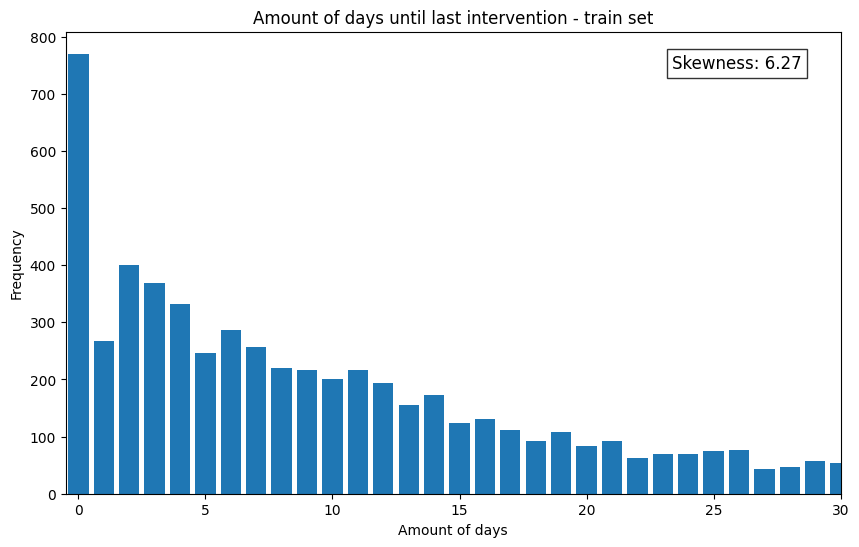

In [27]:
# Store frequencies of train set
No_days_frequencies = y['Dagen_tot_laatst'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(No_days_frequencies.index, No_days_frequencies)

# Add skewness to the plot
plt.text(0.95, 0.95, f'Skewness: {skew(y['Dagen_tot_laatst'], nan_policy='omit'):.2f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

# Add labels and title
plt.xlabel('Amount of days')
plt.ylabel('Frequency')
plt.title('Amount of days until last intervention - train set')
ax = plt.gca()
ax.set_xlim([-0.5, 30])

plt.show()

In [28]:
# Define function to reduce skewness, assuming positive skewness starting the downsampling from class '0'
def reduce_skew(X, y, imbalanced_column: str, final_heavy_class: int, downsampling_perc_heaviest):
    # Create series to store all frequencies
    classes = pd.Series(range(int(y[imbalanced_column].max() + 1)))
    counts = y[imbalanced_column].value_counts().sort_index()
    frequencies = counts.reindex(classes, fill_value=0)

    # Disregard classes exceeding final_heavy_class
    classes_to_downsample = frequencies[:final_heavy_class+1]

    # Calculate median class size for disregarded classes
    subseq_classes = frequencies[final_heavy_class+1:final_heavy_class+round(final_heavy_class*0.25)]
    median_subseq_class_size = np.median(subseq_classes.tolist())

    # Define downsampling percentages for all downsampling classes
    downsampling_percs = []
    indices_removed = []
    max_class_downsample = max(classes_to_downsample) - median_subseq_class_size
    for class_label, class_size in classes_to_downsample.items():
        if class_size > median_subseq_class_size:
            class_size = class_size - median_subseq_class_size
        downsampling_perc = (class_size * downsampling_perc_heaviest) / max_class_downsample
        downsampling_percs.append(downsampling_perc)

        # Calculate amount of instances to be removed
        n = round(class_size * downsampling_perc)
        
        # Randomly choose instances to remove (should this have a random state?)
        class_indices_candidates = y[y[imbalanced_column] == class_label].index
        np.random.seed(42)
        class_indices_remove = np.random.choice(class_indices_candidates, size=int(n), replace=False)
        indices_removed.extend(class_indices_remove)

    # Remove all indices in indices_to_remove from df with inplace=True argument
    y.drop(indices_removed, inplace=True)
    X.drop(indices_removed, inplace=True)

    return X, y

In [29]:
X_reduced, y_reduced = reduce_skew(X, y, 'Dagen_tot_laatst', 25, 0.5)

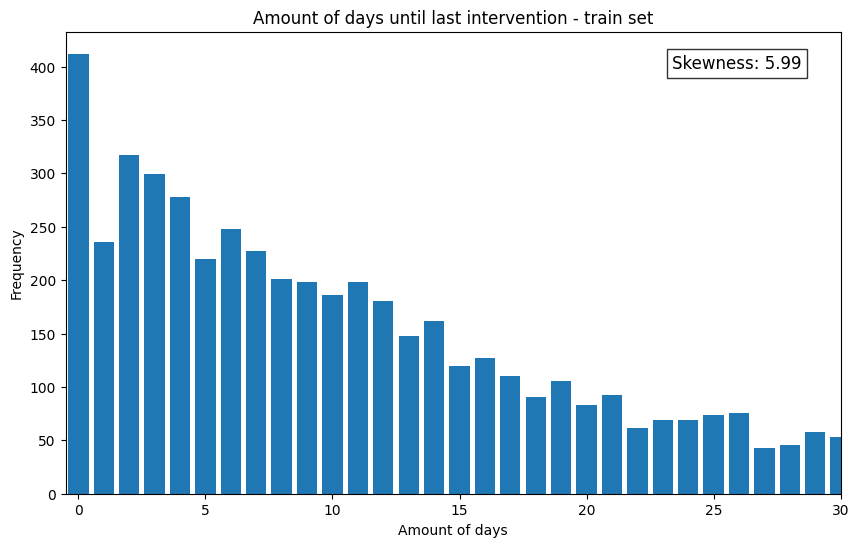

In [30]:
# Store frequencies of train set
No_days_frequencies_postresampling = y_reduced['Dagen_tot_laatst'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(No_days_frequencies_postresampling.index, No_days_frequencies_postresampling)

# Add skewness to the plot
plt.text(0.95, 0.95, f'Skewness: {skew(y_reduced['Dagen_tot_laatst'], nan_policy='omit'):.2f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

# Add labels and title
plt.xlabel('Amount of days')
plt.ylabel('Frequency')
plt.title('Amount of days until last intervention - train set')
ax = plt.gca()
ax.set_xlim([-0.5, 30])

plt.show()

### 8. Split data

In [31]:
# Define cutoff values for train-validation-test splits based on year
train_cutoff = 2020
val_cutoff = 2021
test_cutoff = 2022

# Filter indices based on the cutoff values
train_indices = X.loc[X['year_Datum_melding'] <= train_cutoff].index
val_indices = X.loc[(X['year_Datum_melding'] > train_cutoff) & (X['year_Datum_melding'] <= val_cutoff)].index
test_indices = X.loc[(X['year_Datum_melding'] > val_cutoff) & (X['year_Datum_melding'] <= test_cutoff)].index
oos_indices = X.loc[X['year_Datum_melding'] > test_cutoff].index

# Split X and y into train, validation, and test sets
X_train, X_val, X_test, X_oos = X.loc[train_indices], X.loc[val_indices], X.loc[test_indices], X.loc[oos_indices]
y_train, y_val, y_test, y_oos = y.loc[train_indices], y.loc[val_indices], y.loc[test_indices], y.loc[oos_indices]

### 9. Model selection

#### 9.1 Logistic regression

##### 9.1.1 Training

In [32]:
# Fit logistic regression model
logistic_reg = MultiOutputRegressor(LogisticRegression(random_state=42))
logistic_reg.fit(X_train, y_train)

C:\Users\l.hanen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\l.hanen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

MultiOutputRegressor(estimator=LogisticRegression(random_state=42))

In [33]:
# Predict validation set
y_pred_val_lr = logistic_reg.predict(X_val)

In [34]:
# Iterate over each row of y_pred_val_rf
for i in range(len(y_pred_val_lr)):
    if y_pred_val_lr[i][0] == 0 or y_pred_val_lr[i][1] == 0:
        y_pred_val_lr[i] = [0, 0]

##### 9.1.2 Evaluation metrics on validation set

In [35]:
# Sample y_pred and y_test (assuming they are pandas DataFrames)
y_pred_val_lr_df = pd.DataFrame(y_pred_val_lr,
                                columns=['Dagen_tot_laatst', 'No_interventions'])

# Calculate median absolute error (MAE) for each output separately
lr_mae_val_interventions = round(median_absolute_error(y_val['No_interventions'], y_pred_val_lr_df['No_interventions']), 2)
lr_mae_val_days = round(median_absolute_error(y_val['Dagen_tot_laatst'], y_pred_val_lr_df['Dagen_tot_laatst']), 2)

# Calculate mean absolute percentage error (MAPE) for each output separately
lr_mape_val_interventions = round(mean_absolute_percentage_error(y_val['No_interventions'], y_pred_val_lr_df['No_interventions']), 2)
lr_mape_val_days = round(mean_absolute_percentage_error(y_val['Dagen_tot_laatst'], y_pred_val_lr_df['Dagen_tot_laatst']), 2)

# Calculate mean squared error (MSE) for each output separately
lr_mse_val_interventions = round(mean_squared_error(y_val['No_interventions'], y_pred_val_lr_df['No_interventions']), 2)
lr_mse_val_days = round(mean_squared_error(y_val['Dagen_tot_laatst'], y_pred_val_lr_df['Dagen_tot_laatst']), 2)

# Calculate mean squared log error (MSLE) for each output separately
lr_msle_val_interventions = round(mean_squared_log_error(y_val['No_interventions'], y_pred_val_lr_df['No_interventions']), 2)
lr_msle_val_days = round(mean_squared_log_error(y_val['Dagen_tot_laatst'], y_pred_val_lr_df['Dagen_tot_laatst']), 2)

# Calculate coefficient of determination (R2) for each output separately
lr_r2_val_interventions = round(r2_score(y_val['No_interventions'], y_pred_val_lr_df['No_interventions']), 2)
lr_r2_val_days = round(r2_score(y_val['Dagen_tot_laatst'], y_pred_val_lr_df['Dagen_tot_laatst']), 2)

##### 9.1.3 Feature importance/SHAP values

#### 9.2 Random Forest

##### 9.2.1 Training

In [36]:
# Fit RF regressor
RF = RandomForestRegressor(random_state=42)
RF.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [37]:
# Predict validation set
y_pred_val_rf = RF.predict(X_val)

In [38]:
# Iterate over each row of y_pred_val_rf
for i in range(len(y_pred_val_rf)):
    if y_pred_val_rf[i][0] == 0 or y_pred_val_rf[i][1] == 0:
        y_pred_val_rf[i] = [0, 0]

#### 9.2.2 Evaluation metrics on validation set

In [39]:
# Sample y_pred and y_test (assuming they are pandas DataFrames)
y_pred_val_rf_df = pd.DataFrame(y_pred_val_rf,
                                columns=['Dagen_tot_laatst', 'No_interventions'])

# Calculate median absolute error (MAE) for each output separately
rf_mae_val_interventions = round(median_absolute_error(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2)
rf_mae_val_days = round(median_absolute_error(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2)

# Calculate mean absolute percentage error (MAPE) for each output separately
rf_mape_val_interventions = round(mean_absolute_percentage_error(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2)
rf_mape_val_days = round(mean_absolute_percentage_error(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2)

# Calculate mean squared error (MSE) for each output separately
rf_mse_val_interventions = round(mean_squared_error(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2)
rf_mse_val_days = round(mean_squared_error(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2)

# Calculate mean squared log error (MSLE) for each output separately
rf_msle_val_interventions = round(mean_squared_log_error(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2)
rf_msle_val_days = round(mean_squared_log_error(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2)

# Calculate coefficient of determination (R2) for each output separately
rf_r2_val_interventions = round(r2_score(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2)
rf_r2_val_days = round(r2_score(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2)

#### 9.2.3 Feature importance/SHAP values

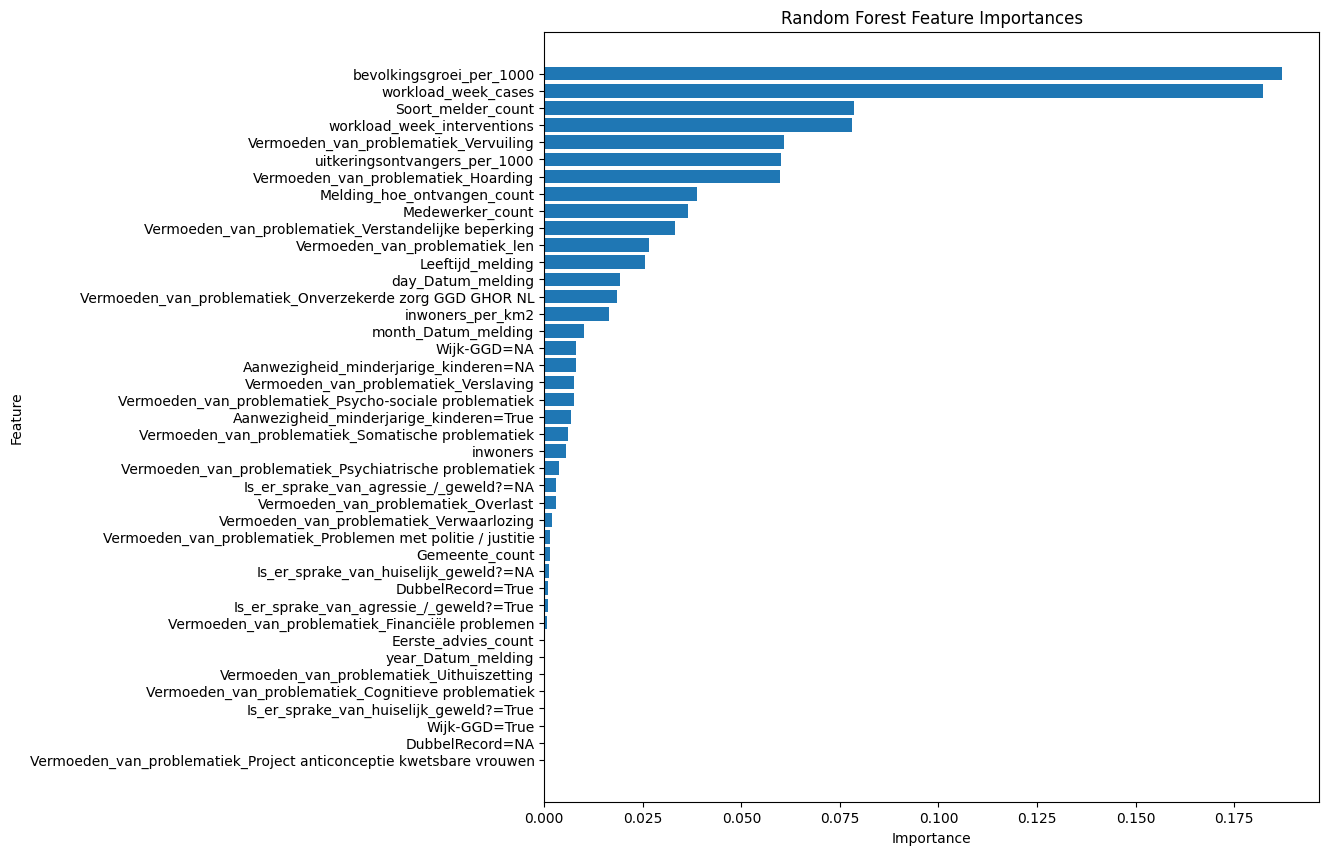

In [40]:
# Store feature importances
rf_estimator = RF.estimators_[0]
rf_importances = pd.DataFrame(rf_estimator.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance')

# Plot the feature importances
plt.figure(figsize=(10, 10))
plt.barh(rf_importances.index, rf_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()

#### 9.3 XGBoost

#### 9.3.1 Training

In [41]:
# Fit XGBoost regressor
xgb_regressor = XGBRegressor(random_state=42)
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [42]:
# Predict validation set
y_pred_val_xgb = xgb_regressor.predict(X_val)

In [43]:
# Iterate over each row of y_pred_val_rf
for i in range(len(y_pred_val_xgb)):
    if y_pred_val_xgb[i][0] == 0 or y_pred_val_xgb[i][1] == 0:
        y_pred_val_xgb[i] = [0, 0]

#### 9.3.2 Evaluation metrics on validation set

In [44]:
# Sample y_pred and y_test (assuming they are pandas DataFrames)
y_pred_val_xgb_df = pd.DataFrame(y_pred_val_xgb,
                                columns=['Dagen_tot_laatst', 'No_interventions'])

# Calculate median absolute error (MAE) for each output separately
xgb_mae_val_interventions = round(median_absolute_error(y_val['No_interventions'], y_pred_val_xgb_df['No_interventions']), 2)
xgb_mae_val_days = round(median_absolute_error(y_val['Dagen_tot_laatst'], y_pred_val_xgb_df['Dagen_tot_laatst']), 2)

# Calculate mean absolute percentage error (MAPE) for each output separately
xgb_mape_val_interventions = round(mean_absolute_percentage_error(y_val['No_interventions'], y_pred_val_xgb_df['No_interventions']), 2)
xgb_mape_val_days = round(mean_absolute_percentage_error(y_val['Dagen_tot_laatst'], y_pred_val_xgb_df['Dagen_tot_laatst']), 2)

# Calculate mean squared error (MSE) for each output separately
xgb_mse_val_interventions = round(mean_squared_error(y_val['No_interventions'], y_pred_val_xgb_df['No_interventions']), 2)
xgb_mse_val_days = round(mean_squared_error(y_val['Dagen_tot_laatst'], y_pred_val_xgb_df['Dagen_tot_laatst']), 2)

# Calculate mean squared log error (MSLE) for each output separately
#xgb_msle_val_interventions = round(mean_squared_log_error(y_val['No_interventions'], y_pred_val_xgb_df['No_interventions']), 2)
#xgb_msle_val_days = round(mean_squared_log_error(y_val['Dagen_tot_laatst'], y_pred_val_xgb_df['Dagen_tot_laatst']), 2)

# Calculate coefficient of determination (R2) for each output separately
xgb_r2_val_interventions = round(r2_score(y_val['No_interventions'], y_pred_val_xgb_df['No_interventions']), 2)
xgb_r2_val_days = round(r2_score(y_val['Dagen_tot_laatst'], y_pred_val_xgb_df['Dagen_tot_laatst']), 2)

#### 9.3.3 Feature importance/SHAP values

#### 9.4 Feed-Forward Neural Network

In [45]:
def get_model(n_inputs, n_outputs):
   model = Sequential()
   model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
   model.add(Dense(n_outputs))
   model.compile(loss='mae', optimizer='adam')
   return model

#### 9.4.1 Training

#### 9.4.2 Evaluation metrics on validation set

#### 9.4.3 Feature importance/SHAP values

#### 9.5 Model comparison

In [46]:
# Prepare data for tabulate
table_data = [
    ['Model', 'Metric', 'Interventions', 'Days'],
    ['Random Forest', 'MAE', rf_mae_val_interventions, rf_mae_val_days],
    ['', 'MAPE', rf_mape_val_interventions, rf_mape_val_days],
    ['', 'MSE', rf_mse_val_interventions, rf_mse_val_days],
    ['', 'MSLE', rf_msle_val_interventions, rf_msle_val_days],
    ['', 'R2', rf_r2_val_interventions, rf_r2_val_days],
    ['XGBoost', 'MAE', xgb_mae_val_interventions, xgb_mae_val_days],
    ['', 'MAPE', xgb_mape_val_interventions, xgb_mape_val_days],
    ['', 'MSE', xgb_mse_val_interventions, xgb_mse_val_days],
    ['', 'MSLE', '', ''], 
    ['', 'R2', xgb_r2_val_interventions, xgb_r2_val_days],
    ['Logistic Regression', 'MAE', lr_mae_val_interventions, lr_mae_val_days],
    ['', 'MAPE', lr_mape_val_interventions, lr_mape_val_days],
    ['', 'MSE', lr_mse_val_interventions, lr_mse_val_days],
    ['', 'MSLE', lr_msle_val_interventions, lr_msle_val_days],
    ['', 'R2', lr_r2_val_interventions, lr_r2_val_days]
]

# Print table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

+---------------------+----------+-------------------+------------------------+
| Model               | Metric   | Interventions     | Days                   |
+=====================+==========+===================+========================+
| Random Forest       | MAE      | 0.84              | 16.37                  |
+---------------------+----------+-------------------+------------------------+
|                     | MAPE     | 481137056642870.4 | 8913033080714158.0     |
+---------------------+----------+-------------------+------------------------+
|                     | MSE      | 7.77              | 3540.58                |
+---------------------+----------+-------------------+------------------------+
|                     | MSLE     | 0.3               | 2.4                    |
+---------------------+----------+-------------------+------------------------+
|                     | R2       | 0.06              | -0.08                  |
+---------------------+----------+------

### 10. In-sample evaluation

### 11. Out-of-sample evaluation